In [1]:
import nltk
import itertools
import random
import time

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

In [3]:
%matplotlib inline

In [4]:
treebank_sents = list(nltk.corpus.treebank.tagged_sents())
print (len(treebank_sents))

random.shuffle(treebank_sents)

test_train_split = 3200
train_sents = treebank_sents[:test_train_split]
test_sents = treebank_sents[test_train_split:]

num_train_baseline = 200
num_tests = 500

3914


In [5]:
def num_tokens(tagged_sents):
    return sum([len(s) for s in tagged_sents])

In [6]:
def default_backoff_tagger(train_sents):
    tags = [tag for sent in treebank_sents for (word, tag) in sent]
    nltk.DefaultTagger(nltk.FreqDist(tags).max())

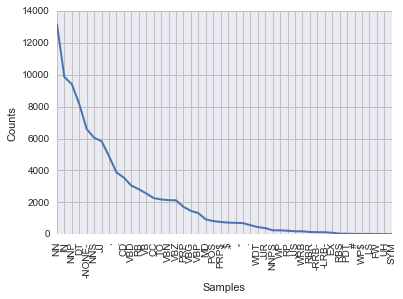

In [7]:
tags = [tag for sent in treebank_sents for (word, tag) in sent]
fd = nltk.FreqDist(tags)
fd.plot()

In [8]:
class TnTTagger(object):   
    def __init__(self, train_size):
        self.train_size = train_size
    
    def train(self, train_sents):
        train_sents = train_sents[:self.train_size]
        self.tokens_size = num_tokens(train_sents)
        
        t0 = default_backoff_tagger(train_sents)
        
        self._tagger = nltk.tag.tnt.TnT(unk=t0)
        self._tagger.train(train_sents)
        
    def test(self, test_sents):
        return self._tagger.evaluate(test_sents)

In [9]:
class TrigramTagger(object): 
    def __init__(self, train_size):
        self.train_size = train_size

    def train(self, train_sents):
        train_sents = train_sents[:self.train_size]
        self.tokens_size = num_tokens(train_sents)
        
        t0 = default_backoff_tagger(train_sents)
        t1 = nltk.tag.UnigramTagger(train_sents, backoff=t0)
        t2 = nltk.tag.BigramTagger(train_sents, backoff=t1)
        
        self._tagger = nltk.tag.TrigramTagger(train_sents, backoff=t2)
        
    def test(self, test_sents):
        return self._tagger.evaluate(test_sents)

In [10]:
class BigramTagger(object): 
    def __init__(self, train_size):
        self.train_size = train_size

    def train(self, train_sents):
        train_sents = train_sents[:self.train_size]
        self.tokens_size = num_tokens(train_sents)
        
        t0 = default_backoff_tagger(train_sents)
        t1 = nltk.tag.UnigramTagger(train_sents, backoff=t0)
        
        self._tagger = nltk.tag.BigramTagger(train_sents, backoff=t1)
        
    def test(self, test_sents):
        return self._tagger.evaluate(test_sents)

In [11]:
class UnigramTagger(object):
    def __init__(self, train_size):
        self.train_size = train_size
    
    def train(self, train_sents):
        train_sents = train_sents[:self.train_size]
        self.tokens_size = num_tokens(train_sents)
        
        t0 = default_backoff_tagger(train_sents)
        
        self._tagger = nltk.tag.UnigramTagger(train_sents, backoff=t0)
        
    def test(self, test_sents):
        return self._tagger.evaluate(test_sents)

In [12]:
def make_taggers(tagger_classes):
    return [c(train_size=(i * num_train_baseline))
        for i, c in itertools.product(range(1, 6), tagger_classes)]

In [13]:
def train_tagger(tagger, train_sents):
        t0 = time.time()
        tagger.train(train_sents)
        train_time = time.time() - t0
#         print ("{:20}{:3.2f}".format(type(tagger).__name__, train_time))
        return train_time

def train_taggers(taggers, train_sents):
    return [train_tagger(t, train_sents) for t in taggers]

In [14]:
def test_tagger(tagger, test_sents):
    t0 = time.time()
    accuracy = tagger.test(test_sents[:num_tests])
    test_time = time.time() - t0
#     print ("{:20}{:3.2f}".format(type(tagger).__name__, test_time))
    return accuracy, test_time
    
def test_taggers(taggers, test_sents):
    return map(list, zip(*[test_tagger(t, test_sents) for t in taggers]))

In [15]:
def my_plot(grouped, field):
    fig, ax = plt.subplots(figsize=(8,6))
    for key, grp in grouped:
        grp.plot(x='tokens_size', y=field, ax=ax, label=key)
    plt.legend(loc='best')
    plt.title(field)
    plt.show()
    
def my_plots(grouped, fields):
    for field in fields:
        my_plot(grouped, field)

In [16]:
def compare_taggers(tagger_classes, train_sents, test_sents):
    taggers = make_taggers(tagger_classes)
    train_times = train_taggers(taggers, train_sents)
    accuracies, test_times = test_taggers(taggers, test_sents)
    
    tagger_types = [type(t).__name__ for t in taggers]
    tokens_sizes = [t.tokens_size for t in taggers]

    test_runs = [('tagger_type', tagger_types),
                 ('tokens_size', tokens_sizes),
                 ('accuracy', accuracies),
                 ('train_time', train_times),
                 ('test_time', test_times)]

    df = pd.DataFrame.from_items(test_runs)
    grouped = df.groupby(['tagger_type'])
    
    my_plots(grouped, ['accuracy', 'train_time', 'test_time'])
    
    return grouped

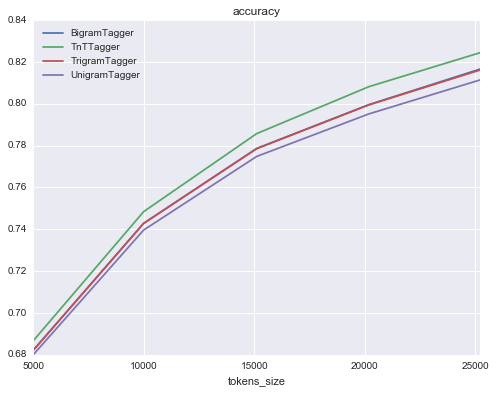

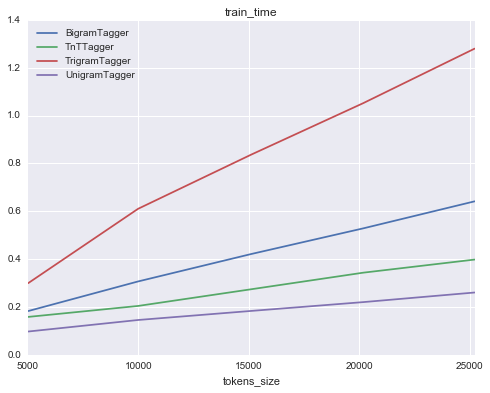

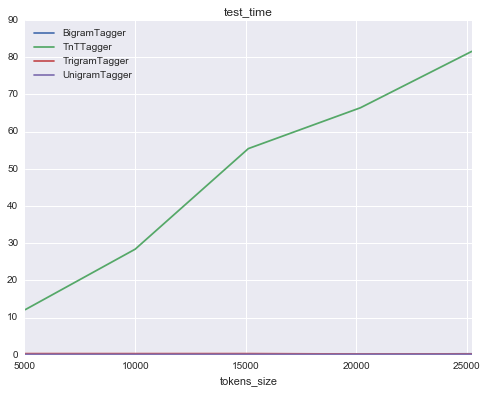

accuracy  test_time   tokens_size  train_time
tagger_type                                                       
BigramTagger  count  5.000000   5.000000      5.000000    5.000000
              mean   0.764002   0.186582  15103.600000    0.416322
              std    0.053244   0.046787   8002.369543    0.180231
              min    0.682437   0.160634   5014.000000    0.182944
              25%    0.742836   0.162395   9989.000000    0.306779
              50%    0.778639   0.167849  15109.000000    0.421402
              75%    0.799549   0.172153  20184.000000    0.528784
              max    0.816548   0.269880  25222.000000    0.641699
TnTTagger     count  5.000000   5.000000      5.000000    5.000000
              mean   0.770711  48.787785  15103.600000    0.275708
              std    0.054812  28.225074   8002.369543    0.098031
              min    0.686950  12.146095   5014.000000    0.158473
              25%    0.748402  28.399997   9989.000000    0.204316
              50%    0.785709  55.428332  15109.000000    0.274089
              75%    0.808123  66.408452  20184.000000    0.343446
              max    0.824370  81.556050  25222.000000    0.398216
TrigramTagger count  5.000000   5.000000      5.000000    5.000000
              mean   0.763821   0.273560  15103.600000    0.815981
              std    0.053134   0.060148   8002.369543    0.381031
              min    0.682362   0.207164   5014.000000    0.299613
              25%    0.742760   0.208192   9989.000000    0.610545
              50%    0.778488   0.316287  15109.000000    0.837053
              75%    0.799398   0.317577  20184.000000    1.052456
              max    0.816096   0.318579  25222.000000    1.280237
UnigramTagger count  5.000000   5.000000      5.000000    5.000000
              mean   0.760226   0.115345  15103.600000    0.181438
              std    0.052116   0.001840   8002.369543    0.063491
              min    0.680256   0.112607   5014.000000    0.097344
              25%    0.739601   0.114644   9989.000000    0.145558
              50%    0.774803   0.115465  15109.000000    0.183461
              75%    0.795111   0.116868  20184.000000    0.220354
              max    0.811358   0.117139  25222.000000    0.260473

In [17]:
tagger_classes = [TnTTagger, TrigramTagger, BigramTagger, UnigramTagger]
grouped = compare_taggers(tagger_classes, train_sents, test_sents)
grouped.describe()

In [18]:
# (N-1)gram vs default

In [19]:
class BigramTaggerDefaultBackoff(object):
    def __init__(self, train_size):
        self.train_size = train_size

    def train(self, train_sents):
        train_sents = train_sents[:self.train_size]
        self.tokens_size = num_tokens(train_sents)
        
        t0 = default_backoff_tagger(train_sents)
        
        self._tagger = nltk.tag.BigramTagger(train_sents, backoff=t0)
        
    def test(self, test_sents):
        return self._tagger.evaluate(test_sents)

In [20]:
class TrigramTaggerDefaultBackoff(object):
    def __init__(self, train_size):
        self.train_size = train_size

    def train(self, train_sents):
        train_sents = train_sents[:self.train_size]
        self.tokens_size = num_tokens(train_sents)
        
        t0 = default_backoff_tagger(train_sents)
        
        self._tagger = nltk.tag.TrigramTagger(train_sents, backoff=t0)
        
    def test(self, test_sents):
        return self._tagger.evaluate(test_sents)

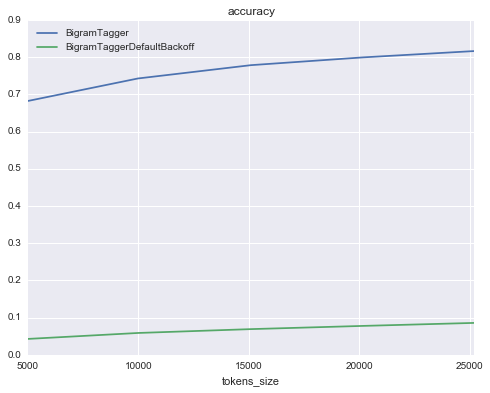

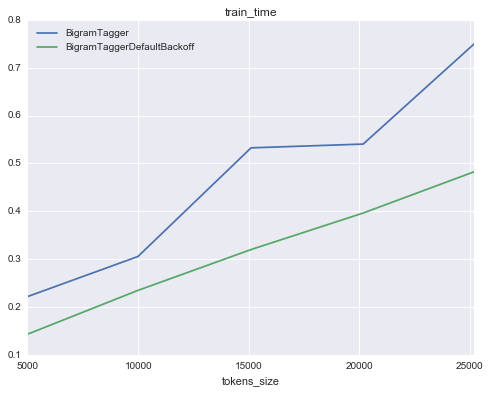

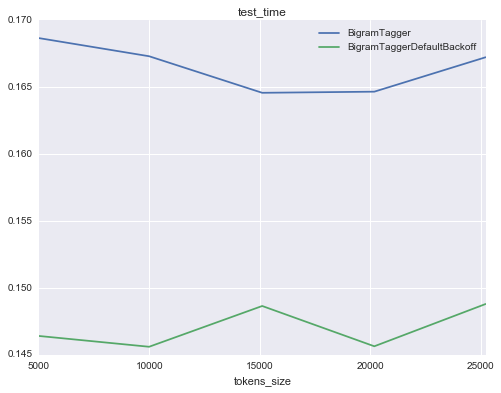

accuracy  test_time   tokens_size  \
tagger_type                                                           
BigramTagger               count  5.000000   5.000000      5.000000   
                           mean   0.764002   0.166474  15103.600000   
                           std    0.053244   0.001797   8002.369543   
                           min    0.682437   0.164564   5014.000000   
                           25%    0.742836   0.164648   9989.000000   
                           50%    0.778639   0.167218  15109.000000   
                           75%    0.799549   0.167294  20184.000000   
                           max    0.816548   0.168645  25222.000000   
BigramTaggerDefaultBackoff count  5.000000   5.000000      5.000000   
                           mean   0.066777   0.147016  15103.600000   
                           std    0.016798   0.001589   8002.369543   
                           min    0.042723   0.145600   5014.000000   
                           25%    0.058669   0.145636   9989.000000   
                           50%    0.069049   0.146404  15109.000000   
                           75%    0.077698   0.148645  20184.000000   
                           max    0.085747   0.148793  25222.000000   

                                  train_time  
tagger_type                                   
BigramTagger               count    5.000000  
                           mean     0.470319  
                           std      0.209861  
                           min      0.222134  
                           25%      0.305531  
                           50%      0.532715  
                           75%      0.540558  
                           max      0.750655  
BigramTaggerDefaultBackoff count    5.000000  
                           mean     0.315527  
                           std      0.132954  
                           min      0.143518  
                           25%      0.234706  
                           50%      0.320062  
                           75%      0.396424  
                           max      0.482927

In [21]:
tagger_classes = [BigramTagger, BigramTaggerDefaultBackoff]
grouped = compare_taggers(tagger_classes, train_sents, test_sents)
grouped.describe()

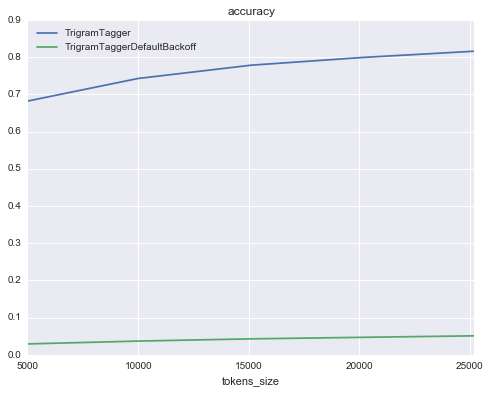

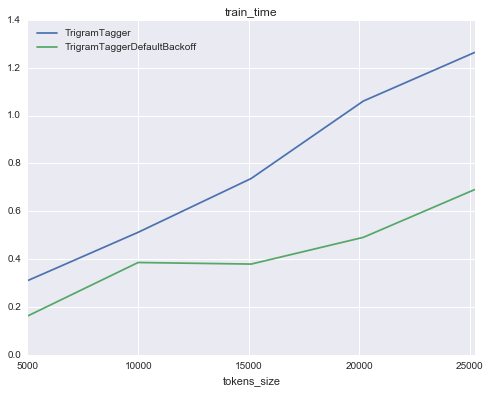

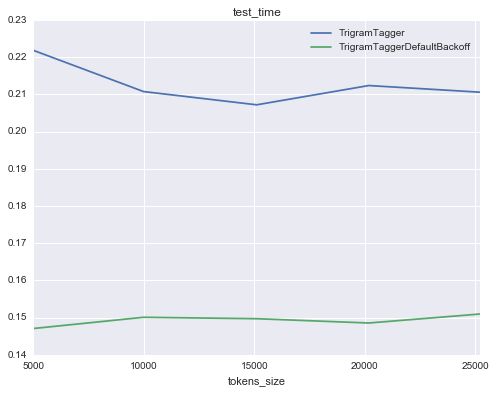

accuracy  test_time   tokens_size  \
tagger_type                                                            
TrigramTagger               count  5.000000   5.000000      5.000000   
                            mean   0.763821   0.212549  15103.600000   
                            std    0.053134   0.005510   8002.369543   
                            min    0.682362   0.207201   5014.000000   
                            25%    0.742760   0.210593   9989.000000   
                            50%    0.778488   0.210760  15109.000000   
                            75%    0.799398   0.212381  20184.000000   
                            max    0.816096   0.221810  25222.000000   
TrigramTaggerDefaultBackoff count  5.000000   5.000000      5.000000   
                            mean   0.041399   0.149275  15103.600000   
                            std    0.008570   0.001504   8002.369543   
                            min    0.029259   0.147077   5014.000000   
                            25%    0.036856   0.148549   9989.000000   
                            50%    0.042873   0.149699  15109.000000   
                            75%    0.047010   0.150086  20184.000000   
                            max    0.050997   0.150965  25222.000000   

                                   train_time  
tagger_type                                    
TrigramTagger               count    5.000000  
                            mean     0.777177  
                            std      0.389460  
                            min      0.311218  
                            25%      0.512159  
                            50%      0.737288  
                            75%      1.060991  
                            max      1.264231  
TrigramTaggerDefaultBackoff count    5.000000  
                            mean     0.422107  
                            std      0.191679  
                            min      0.163416  
                            25%      0.379405  
                            50%      0.385914  
                            75%      0.491086  
                            max      0.690715

In [22]:
tagger_classes = [TrigramTagger, TrigramTaggerDefaultBackoff]
grouped = compare_taggers(tagger_classes, train_sents, test_sents)
grouped.describe()